# Model 

In [279]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, Module, Parameter, ReLU, Sequential, LeakyReLU, Dropout, BatchNorm1d
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import wandb
from data_transformer.data_transformer import DataTransformer
from data_analyse.preprocessing import DataPreprocessor
from sklearn.decomposition import PCA
from data_analyse.analyse import DataAnalyzer
import os
from datetime import datetime, timezone
from data_analyse.evaluation import SyntheticDataEvaluator

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
def date_et_temps_utc():
    return datetime.now(timezone.utc).strftime("%Y-%m-%d %H:%M:%S %Z")
class Encoder(Module):
    def __init__(self, data_dim, compress_dims, latent_dim):
        super().__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, latent_dim)
        self.fc2 = Linear(dim, latent_dim)

    def forward(self, input_):
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    def __init__(self, latent_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = latent_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item),  BatchNorm1d(item), LeakyReLU(), Dropout()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, output_info):
    st = 0
    loss = []
    for column_info in output_info:
        for span_info in column_info:
            if span_info.activation_fn != 'softmax':
                ed = st + span_info.dim
                std = sigmas[st]
                eq = x[:, st] - torch.tanh(recon_x[:, st])
                loss.append((eq**2 / 2 / (std**2)).sum())
                loss.append(torch.log(std) * x.size()[0])
                st = ed

            else:
                ed = st + span_info.dim
                loss.append(
                    cross_entropy(
                        recon_x[:, st:ed], torch.argmax(x[:, st:ed], dim=-1), reduction='sum'
                    )
                )
                st = ed

    assert st == recon_x.size()[1]
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss)  / x.size()[0], KLD / x.size()[0]


class TVAE():

    def __init__(
        self,
        latent_dim=128,
        compress_dims=(128, 128),
        decompress_dims=(128, 128),
        l2scale=1e-5,
        batch_size=500,
        epochs=300,
        loss_factor=2,
        cuda=True,
        verbose=False,
        track = False
    ):
        self.latent_dim = latent_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims
        self.encoder = None
        self.decoder = None
        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.verbose = verbose
        self.track = track
        self.transformer = None
        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)
 
    def fit(self, train_data, discrete_columns=(), val_split=0.2, early_stopping_patience=20, early_stopping_delta=0.001, lr = 0.001, patience_beta = None, project = "Data Augmentation"):
        if self.track:
            wandb.init(project=project, name=date_et_temps_utc(), config={
                "latent_dim": self.latent_dim,
                "compress_dims": self.compress_dims,
                "decompress_dims": self.decompress_dims,
                "l2scale": self.l2scale,
                "batch_size": self.batch_size,
                "epochs": self.epochs,
                "loss_factor": self.loss_factor,
                "val_split": val_split,
                "early_stopping_patience": early_stopping_patience,
                "early_stopping_delta": early_stopping_delta
            })
        self.transformer = DataTransformer()
        self.transformer.fit(train_data, discrete_columns)
        transformed_data = self.transformer.transform(train_data)
        
        data_size = len(transformed_data)
        indices = np.arange(data_size)
        np.random.shuffle(indices)
        
        val_size = int(data_size * val_split)
        train_indices = indices[val_size:]
        val_indices = indices[:val_size]
        
        train_data = transformed_data[train_indices]
        val_data = transformed_data[val_indices]
        
        train_dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        val_dataset = TensorDataset(torch.from_numpy(val_data.astype('float32')).to(self._device))
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False)
        
        data_dim = self.transformer.output_dimensions
        self.encoder = Encoder(data_dim, self.compress_dims, self.latent_dim).to(self._device)
        self.decoder = Decoder(self.latent_dim, self.decompress_dims, data_dim).to(self._device)
        
        optimizer = Adam(
            list(self.encoder.parameters()) + list(self.decoder.parameters()), 
            weight_decay=self.l2scale,
            lr=lr
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min',
            factor=0.5,    
            patience=5,     
            min_lr=1e-6   
        )
        best_val_loss = float('inf')
        early_stopping_counter = 0
        best_model_state = None

        if patience_beta:
            is_des = True
            loss_KL_val = []
            wait_beta = 0
        else:
            is_des = False
        for epoch in range(self.epochs):
            self.encoder.train()
            self.decoder.train()
            train_loss = 0
            train_loss1 = 0 
            train_loss2 = 0  
            batch_count = 0
            loss_KL_train_small = []
            for data in train_loader:
                optimizer.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = self.encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.transformer.output_info_list,
                )
                #loss_KL_train_small.append(loss_2)
                loss = loss_1 + loss_2*self.loss_factor
                loss.backward()
                optimizer.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)
                train_loss += loss.item()
                train_loss1 += loss_1.item()
                train_loss2 += loss_2.item()
                batch_count += 1
            avg_train_loss = train_loss / batch_count
            avg_train_loss1 = train_loss1 / batch_count
            avg_train_loss2 = train_loss2 / batch_count
            
            self.encoder.eval()
            self.decoder.eval()
            val_loss = 0
            val_loss1 = 0
            val_loss2 = 0
            batch_count = 0

                
            with torch.no_grad():
                for data in val_loader:
                    real = data[0].to(self._device)
                    mu, std, logvar = self.encoder(real)
                    eps = torch.randn_like(std)
                    emb = eps * std + mu
                    rec, sigmas = self.decoder(emb)
                    loss_1, loss_2 = _loss_function(
                        rec,
                        real,
                        sigmas,
                        mu,
                        logvar,
                        self.transformer.output_info_list,
                    )
                    loss = loss_1 + loss_2*self.loss_factor
                    val_loss += loss.item()
                    val_loss1 += loss_1.item()
                    val_loss2 += loss_2.item()
                    batch_count += 1
            
            avg_val_loss = val_loss / batch_count
            avg_val_loss1 = val_loss1 / batch_count
            avg_val_loss2 = val_loss2 / batch_count
            
            scheduler.step(avg_val_loss)
            if is_des:
                loss_KL_val.append(avg_train_loss2)
                if len(loss_KL_val) > 1:
                    if loss_KL_val[-1] > loss_KL_val[-2]:
                        if wait_beta >= patience_beta:
                            self.loss_factor = self.loss_factor*2
                            wait_beta = 0
                        else:
                            wait_beta += 1

            current_lr = optimizer.param_groups[0]['lr']
            if self.track :
                wandb.log({
                    "epoch": epoch,
                    "train_loss": avg_train_loss,
                    "train_reconstruction_loss": avg_train_loss1,
                    "train_kl_divergence_loss": avg_train_loss2,
                    "val_loss": avg_val_loss,
                    "val_reconstruction_loss": avg_val_loss1,
                    "val_kl_divergence_loss": avg_val_loss2,
                    "learning_rate": current_lr
                })
            if self.verbose :
                if epoch % 5 == 0 or epoch == self.epochs - 1:
                    print(f"Epoch {epoch}/{self.epochs} - "
                          f"Train Loss: {avg_train_loss:.4f} (Rec: {avg_train_loss1:.4f}, KL: {avg_train_loss2:.4f}), "
                          f"Val Loss: {avg_val_loss:.4f} (Rec: {avg_val_loss1:.4f}, KL: {avg_val_loss2:.4f}), "
                          f"LR: {current_lr:.6f}, "
                          f"Patient: {early_stopping_counter}/{early_stopping_patience} ")
            if avg_val_loss < best_val_loss - early_stopping_delta:
                best_val_loss = avg_val_loss
                early_stopping_counter = 0
                
                best_model_state = {
                    'encoder': self.encoder.state_dict(),
                    'decoder': self.decoder.state_dict(),
                    'epoch': epoch,
                    'val_loss': avg_val_loss
                }
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
                    if self.track:
                        wandb.log({"early_stopping": epoch})
                    if best_model_state:
                        self.encoder.load_state_dict(best_model_state['encoder'])
                        self.decoder.load_state_dict(best_model_state['decoder'])
                    
                    break

        if early_stopping_counter < early_stopping_patience and best_model_state:
            self.encoder.load_state_dict(best_model_state['encoder'])
            self.decoder.load_state_dict(best_model_state['decoder'])
        if self.track:
            wandb.finish()
            
    def sample(self, samples):
        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.latent_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake.detach().cpu().numpy())
        data = np.concatenate(data, axis=0)
        data = data[:samples]
        return self.transformer.inverse_transform(data, sigmas.detach().cpu().numpy())

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)
        
    def save(self):
        if self.encoder is None or self.decoder is None:
            raise RuntimeError("Model not trained. Call fit() first.")
        is_saved = False
        file_name = input("Tap model's name:" )
        while not is_saved:
            if os.path.exists(f"models/{file_name}.pth"):
                print("Model's name existes!!!!")
                file_name = input("Tap model's name:" )
            else:
                torch.save(self,f"models/{file_name}.pth")
                is_saved = True
                print("Done!!!!")
        return 1
    def load(self, file_name):
        model = torch.load(f"models/{file_name}.pth", map_location=self._device, weights_only=False)
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.latent_dim = model.latent_dim
        self.compress_dims = model.compress_dims
        self.decompress_dims = model.decompress_dims
        self.transformer = model.transformer

        

# Preprocessing

In [451]:
data = pd.read_csv('data/DataModified.csv', sep=',')
cat_cols = ["CONFIG", "T", "EQUIPEMENT", "FREQUENCE"]
num_cols = ["DATA", "DELTA", "MESURE A", "MESURE A REF", "MESURE B"] 
param_cols = cat_cols +num_cols
preprocessor = DataPreprocessor(
        categorical_cols=cat_cols,
        numerical_cols=num_cols)
cleaned_data, cleaned_output = preprocessor.preprocess(data, cut  = True)
n_data = cleaned_data.shape[0]

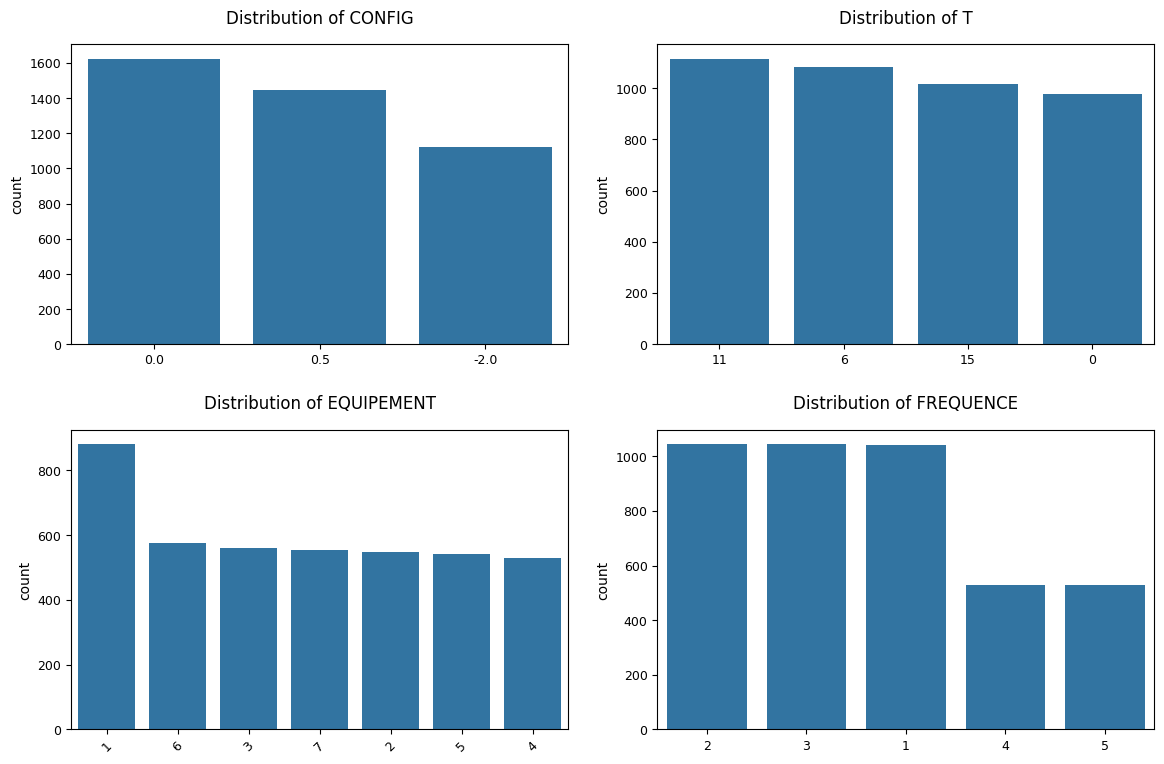

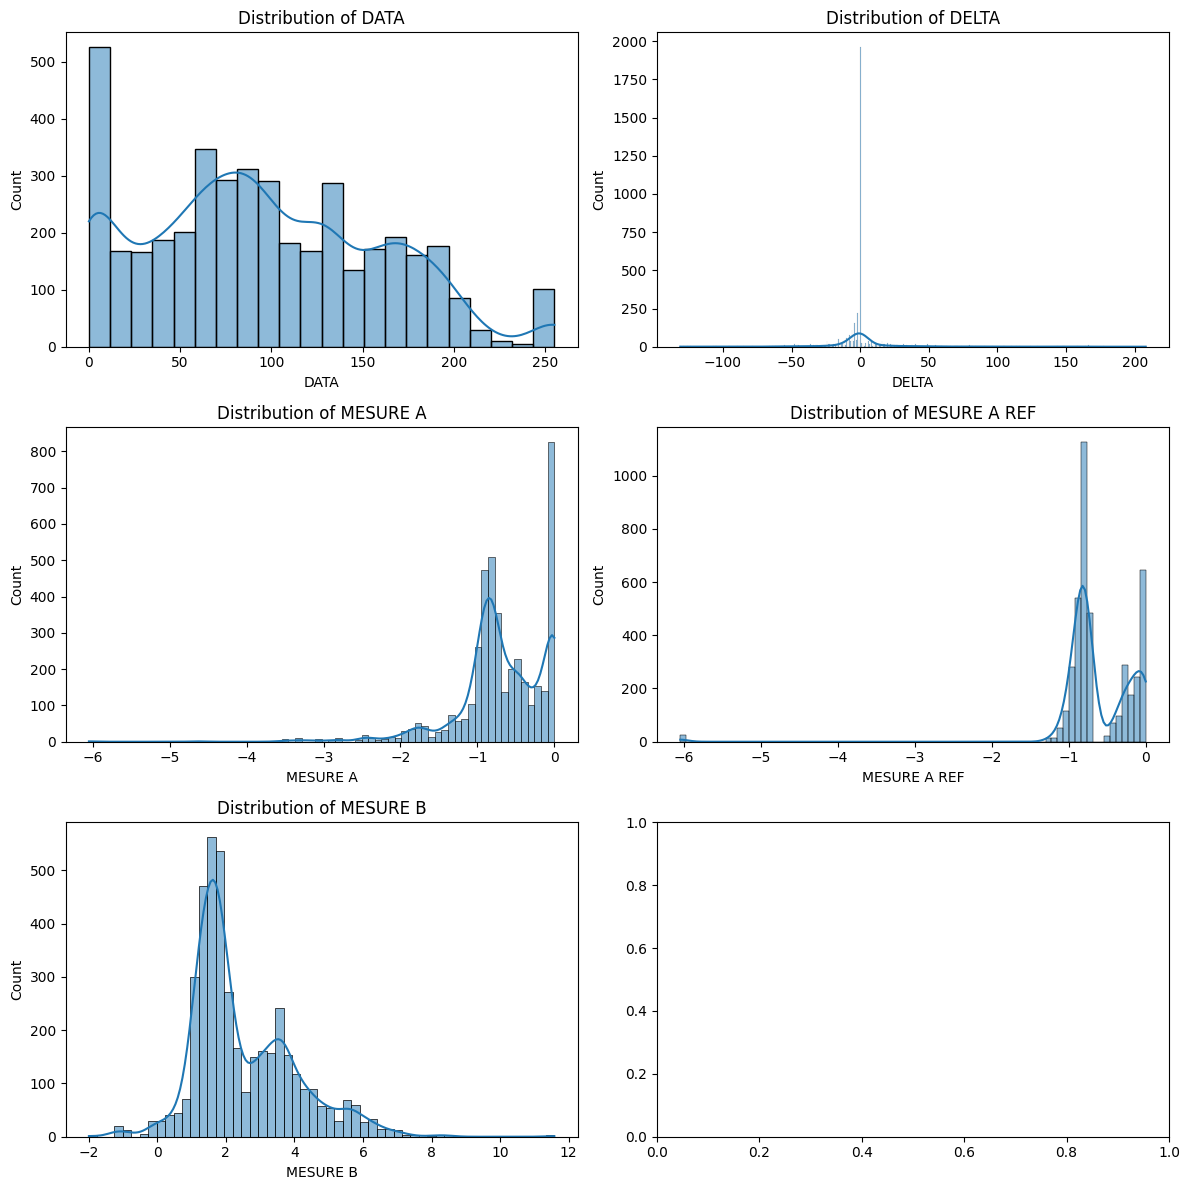

In [479]:
analyzer = DataAnalyzer(cleaned_data, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()
num_plot = analyzer.plot_distributions()

# Train using PCA

In [469]:
trainable_data_pca, pca = preprocessor.apply_pca(cleaned_data, cleaned_output, n_components= 23)

Information kept: 99.999763005%


In [471]:
tvae_pca = TVAE(compress_dims= (512,256), decompress_dims= (256,512),latent_dim=256,track= True, verbose= True, loss_factor= 0.3,batch_size=300, epochs= 1000)
tvae_pca.fit(train_data= trainable_data_pca, discrete_columns= param_cols, lr= 0.01, project="TVAE_PCA")

Epoch 0/1000 - Train Loss: 322.2722 (Rec: 296.0084, KL: 87.5460), Val Loss: 136.6965 (Rec: 132.8636, KL: 12.7766), LR: 0.010000, Patient: 0/20 
Epoch 5/1000 - Train Loss: 68.6942 (Rec: 65.4053, KL: 10.9632), Val Loss: 59.5909 (Rec: 59.1268, KL: 1.5468), LR: 0.010000, Patient: 0/20 
Epoch 10/1000 - Train Loss: 64.2250 (Rec: 62.3903, KL: 6.1158), Val Loss: 58.2735 (Rec: 58.0535, KL: 0.7334), LR: 0.010000, Patient: 1/20 
Epoch 15/1000 - Train Loss: 62.2018 (Rec: 61.2535, KL: 3.1612), Val Loss: 57.1856 (Rec: 57.1321, KL: 0.1783), LR: 0.010000, Patient: 1/20 
Epoch 20/1000 - Train Loss: 60.1193 (Rec: 59.5054, KL: 2.0466), Val Loss: 56.8824 (Rec: 56.8159, KL: 0.2218), LR: 0.010000, Patient: 1/20 
Epoch 25/1000 - Train Loss: 57.3626 (Rec: 56.8693, KL: 1.6441), Val Loss: 56.0307 (Rec: 55.8607, KL: 0.5667), LR: 0.010000, Patient: 0/20 
Epoch 30/1000 - Train Loss: 55.3441 (Rec: 54.6848, KL: 2.1977), Val Loss: 55.2204 (Rec: 54.9156, KL: 1.0162), LR: 0.010000, Patient: 0/20 
Epoch 35/1000 - Train 

early_stopping,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
learning_rate,████████████████████████▄▄▄▄▄▄▄▄▄▄▃▁▁▁▁▁
train_kl_divergence_loss,▂▁▂▃▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇██████████████
train_loss,█▆▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_reconstruction_loss,███▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_kl_divergence_loss,▆▁▁▂▂▃▄▄▄▄▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇███████████████
val_loss,██▇▇▆▆▆▅▅▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
early_stopping,480
epoch,480


In [495]:
tvae_pca.save()

Tap model's name: tvae0


Done!!!!


1

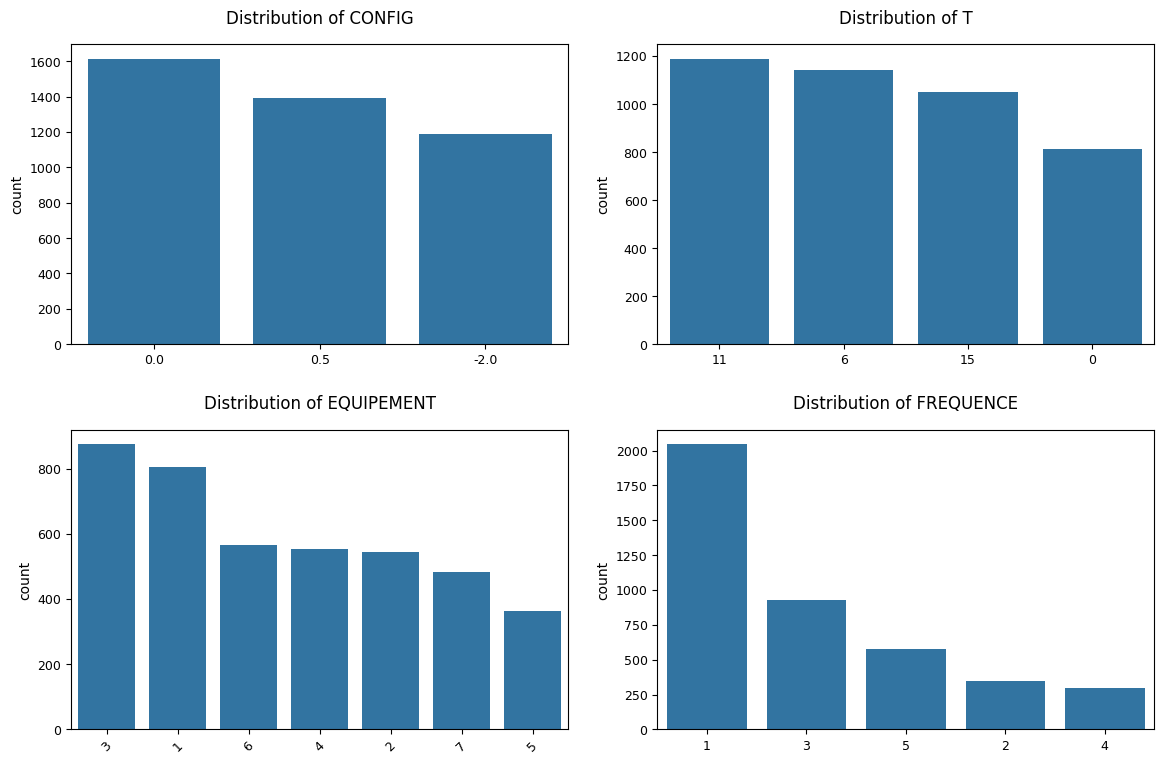

In [473]:
n = n_data
synthetic_data = tvae_pca.sample(n)
output = pd.DataFrame(synthetic_data.iloc[:,9:])
output_inverse = pca.inverse_transform([synthetic_data.iloc[:,9:]])
output_inverse = pd.DataFrame(output_inverse[0], columns=[f'OUTPUT_{i}' for i in range(101 - output_inverse.shape[2], 101)])
synthetic_data_pca = pd.concat([synthetic_data.iloc[:,:9], output_inverse], axis=1)

analyzer_pca = DataAnalyzer(synthetic_data_pca, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot_pca = analyzer_pca.plot_distributions_cat()

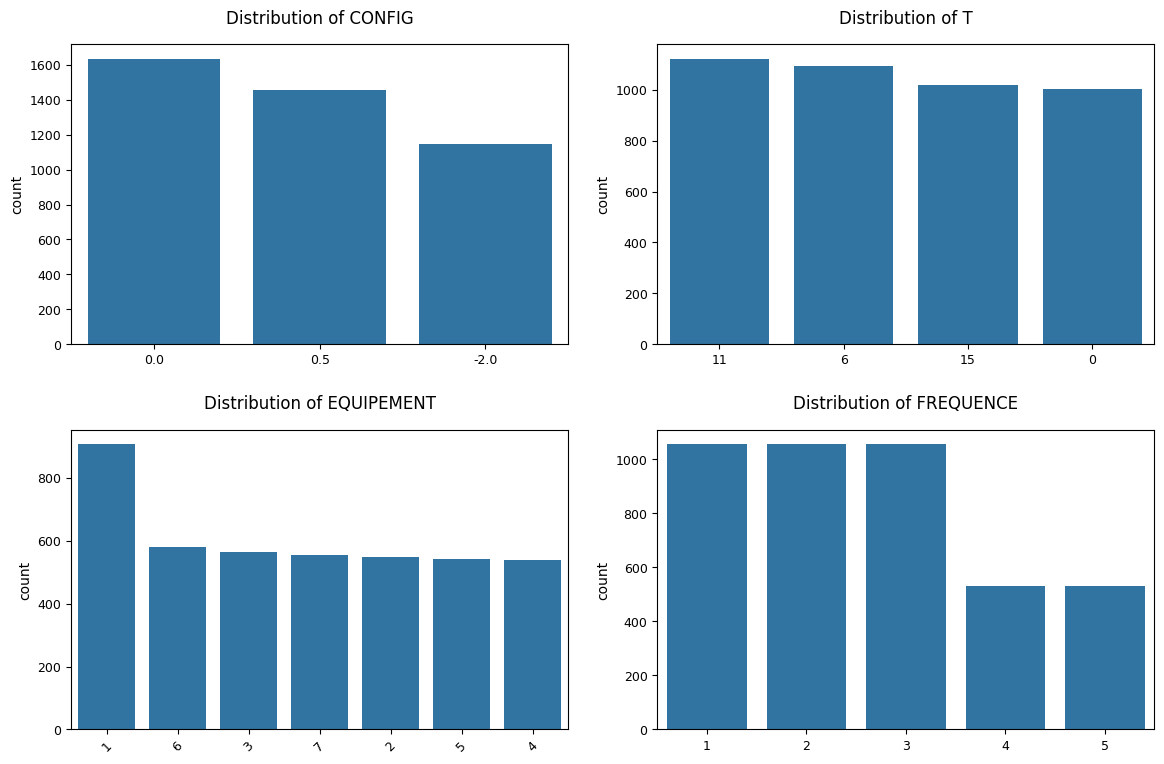

In [235]:
cat_plot

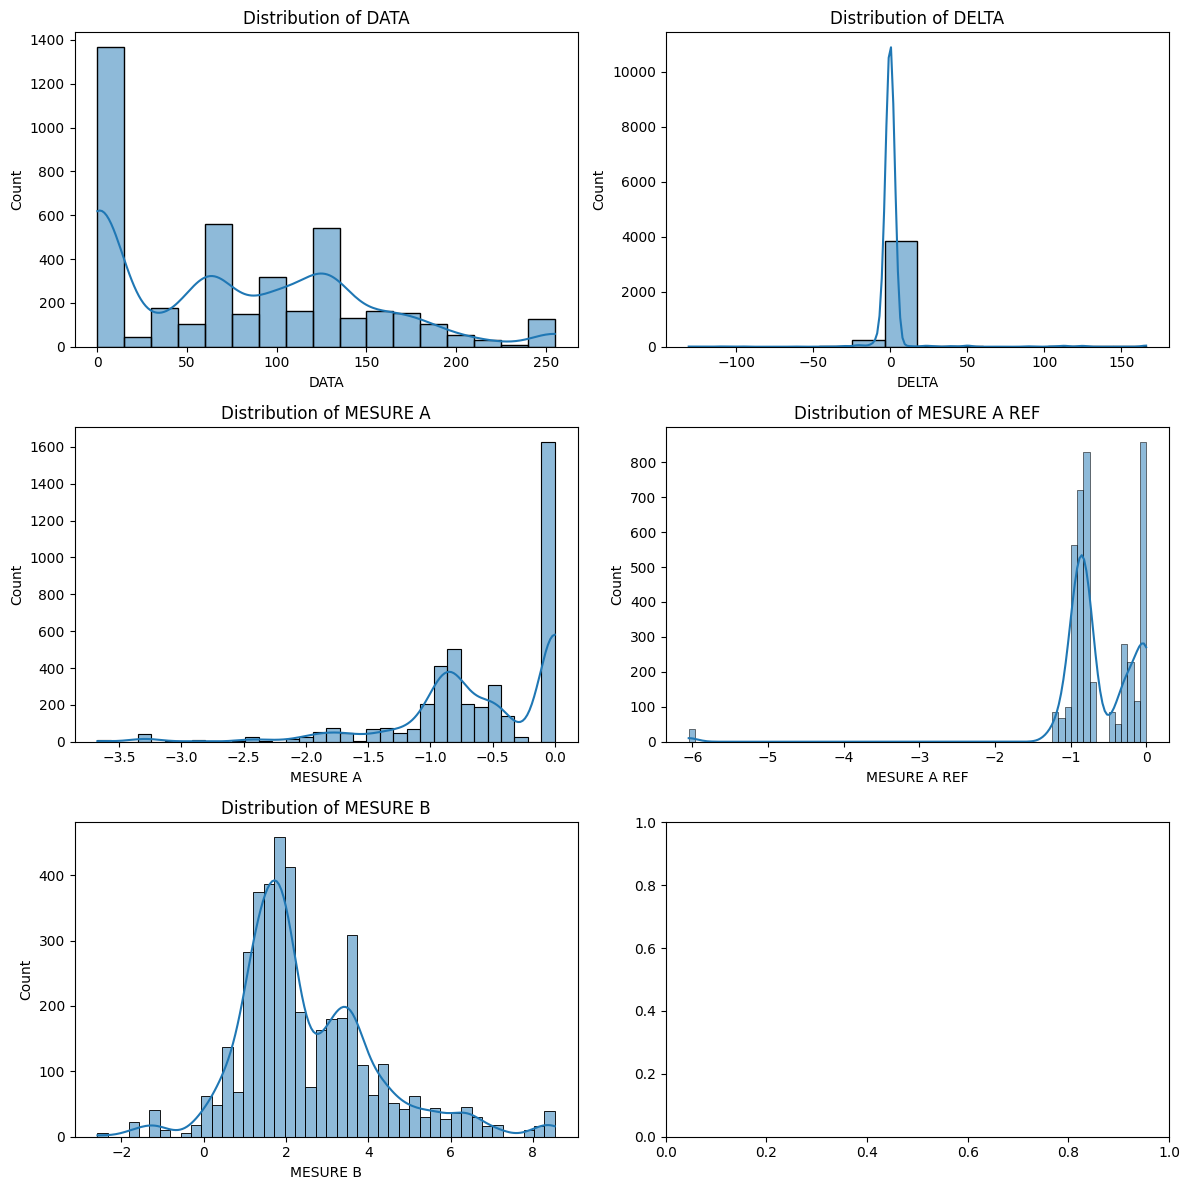

In [405]:
dis_plot_pca = analyzer_pca.plot_distributions()

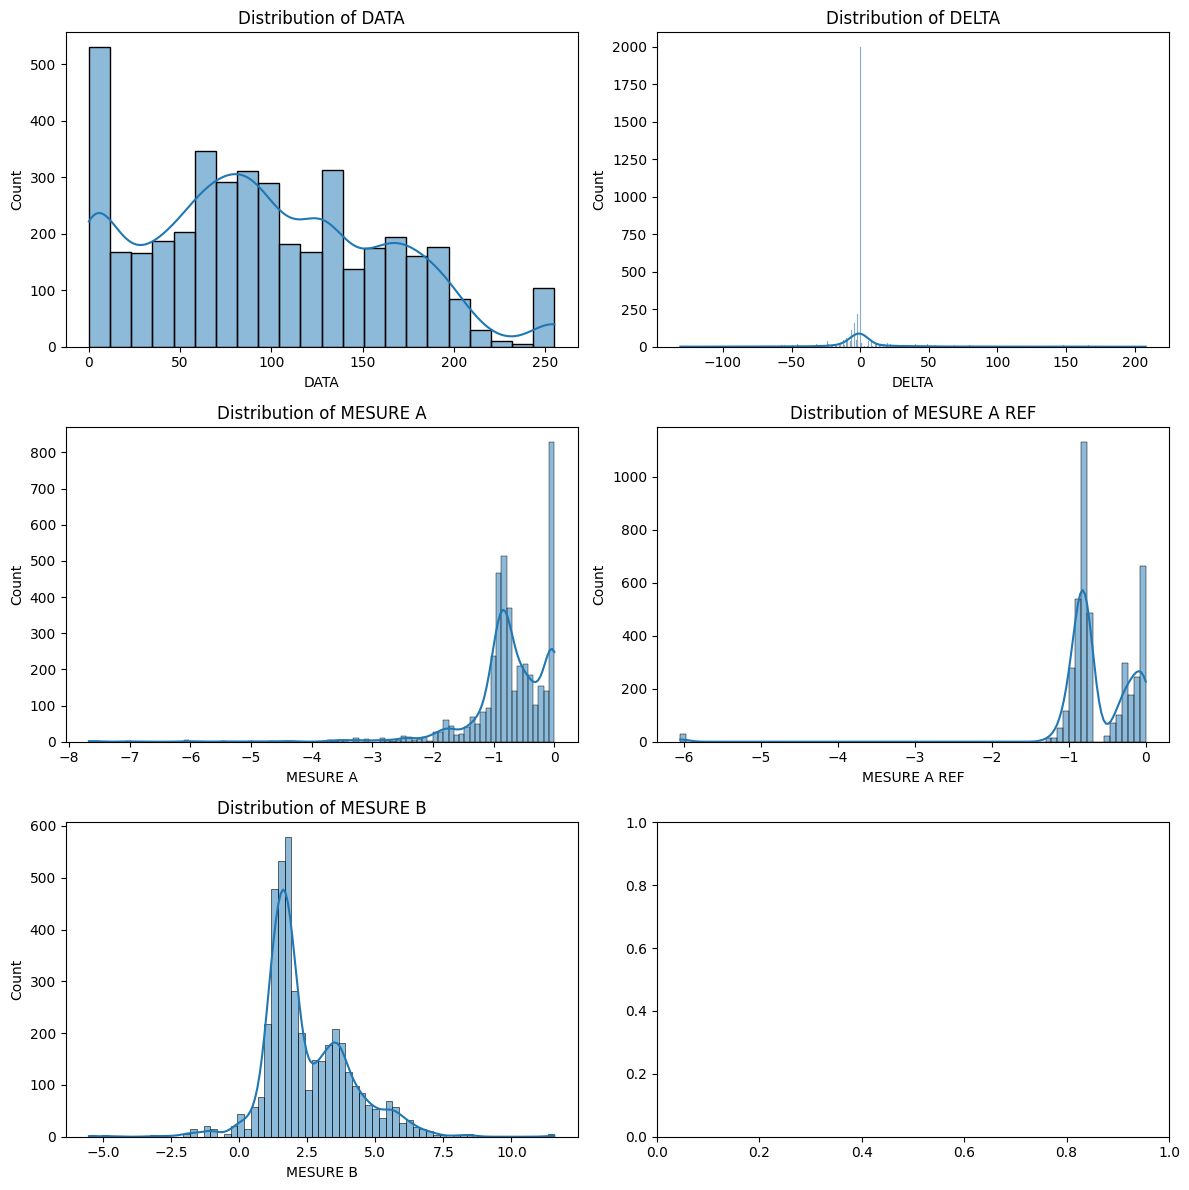

In [54]:
num_plot

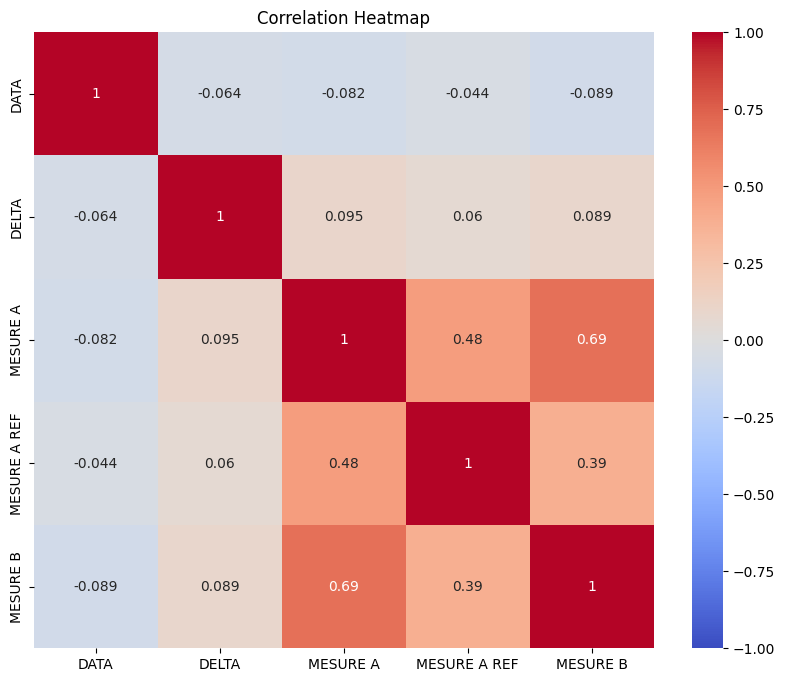

In [407]:
heat_map = analyzer_pca.plot_correlation_heatmap()

In [155]:
synthetic_data.describe()

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,OUTPUT_0,...,OUTPUT_91,OUTPUT_92,OUTPUT_93,OUTPUT_94,OUTPUT_95,OUTPUT_96,OUTPUT_97,OUTPUT_98,OUTPUT_99,OUTPUT_100
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,86.617250,-0.254250,7.789000,3.67575,1.861500,-0.659354,-0.596912,2.372260,2.857250,38.227227,...,98.454708,98.475394,98.492163,98.503716,98.512228,98.517012,98.519994,98.520516,98.520846,98.519156
std,63.598152,0.916347,5.100439,2.05199,26.114762,0.650508,0.559554,1.611361,1.256092,1.194254,...,2.277111,2.312892,2.342573,2.367309,2.385625,2.401094,2.412171,2.421224,2.427189,2.432137
min,0.000000,-2.000000,0.000000,1.00000,-131.000000,-7.673330,-6.049308,-5.529413,1.000000,34.214608,...,90.682772,90.664199,90.658693,90.610414,90.576703,90.546819,90.524265,90.505684,90.490014,90.479460
25%,34.000000,0.000000,6.000000,2.00000,0.000000,-0.927625,-0.851353,1.352891,2.000000,37.415276,...,97.297001,97.304466,97.273071,97.265630,97.254688,97.252800,97.238272,97.228834,97.230186,97.222645
50%,88.000000,0.000000,6.000000,4.00000,0.000000,-0.691777,-0.773973,1.847808,3.000000,38.207285,...,98.766862,98.761574,98.774274,98.779182,98.768921,98.768880,98.767223,98.764320,98.759851,98.754050
75%,128.000000,0.500000,11.000000,5.00000,0.000000,0.000000,-0.133848,3.281309,3.000000,39.003847,...,100.037919,100.102294,100.142104,100.173052,100.197495,100.202424,100.207844,100.203645,100.216262,100.218287
max,255.000000,0.500000,15.000000,7.00000,208.000000,0.000000,0.000000,11.580734,5.000000,43.346070,...,104.734520,104.780095,104.816439,104.831295,104.838862,104.843844,104.837266,104.872713,104.916838,104.954324


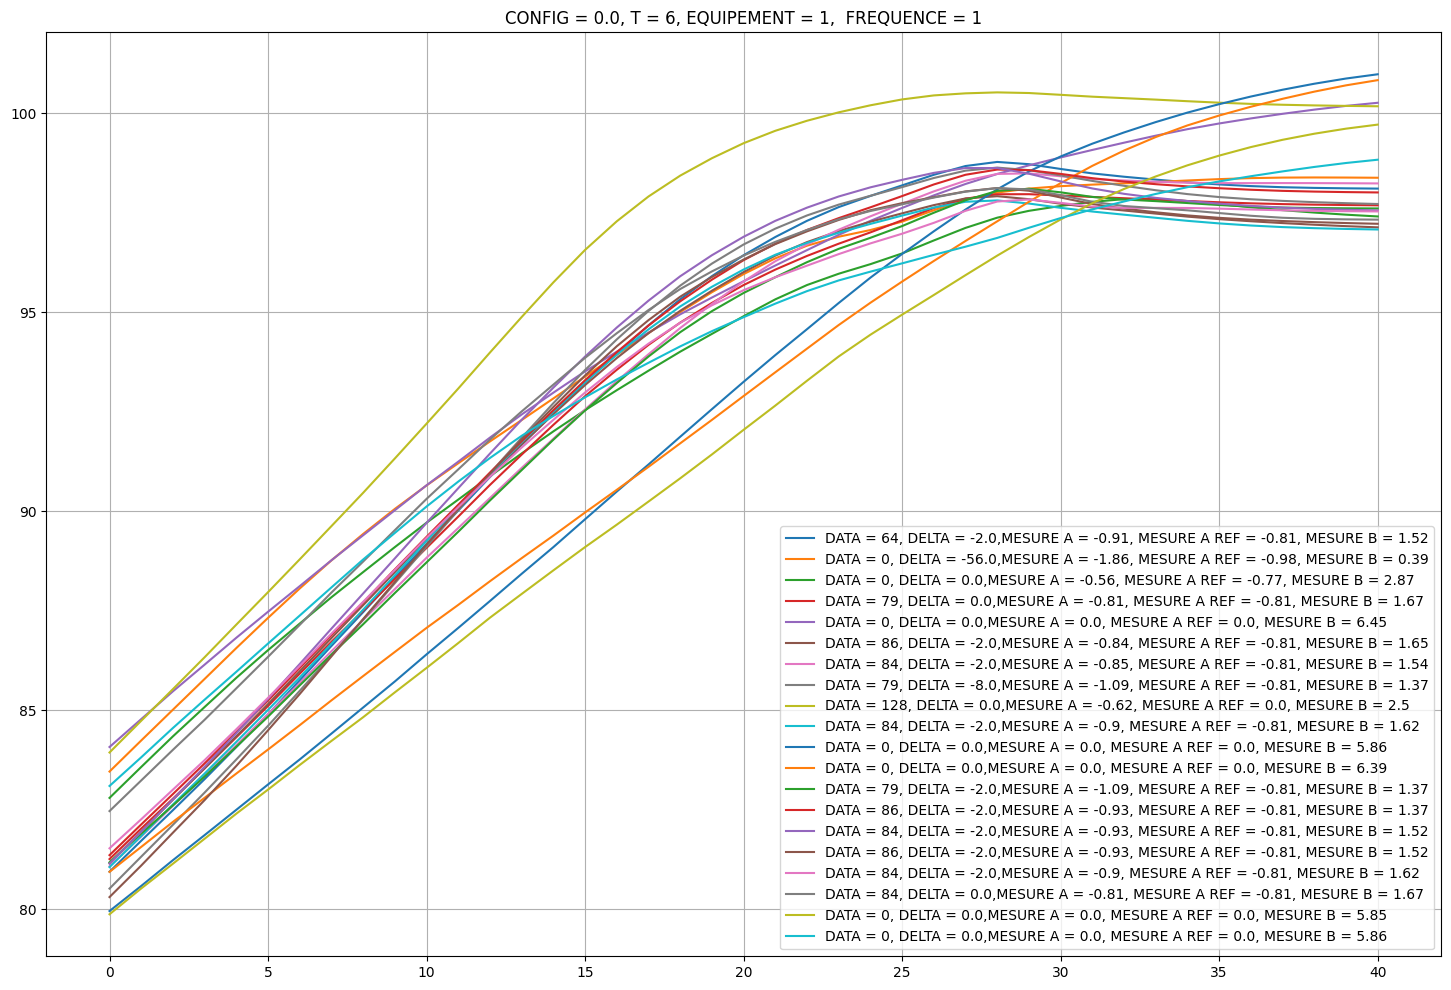

In [485]:
analyzer_pca.plot_syn_data({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1
}, noutput=20)

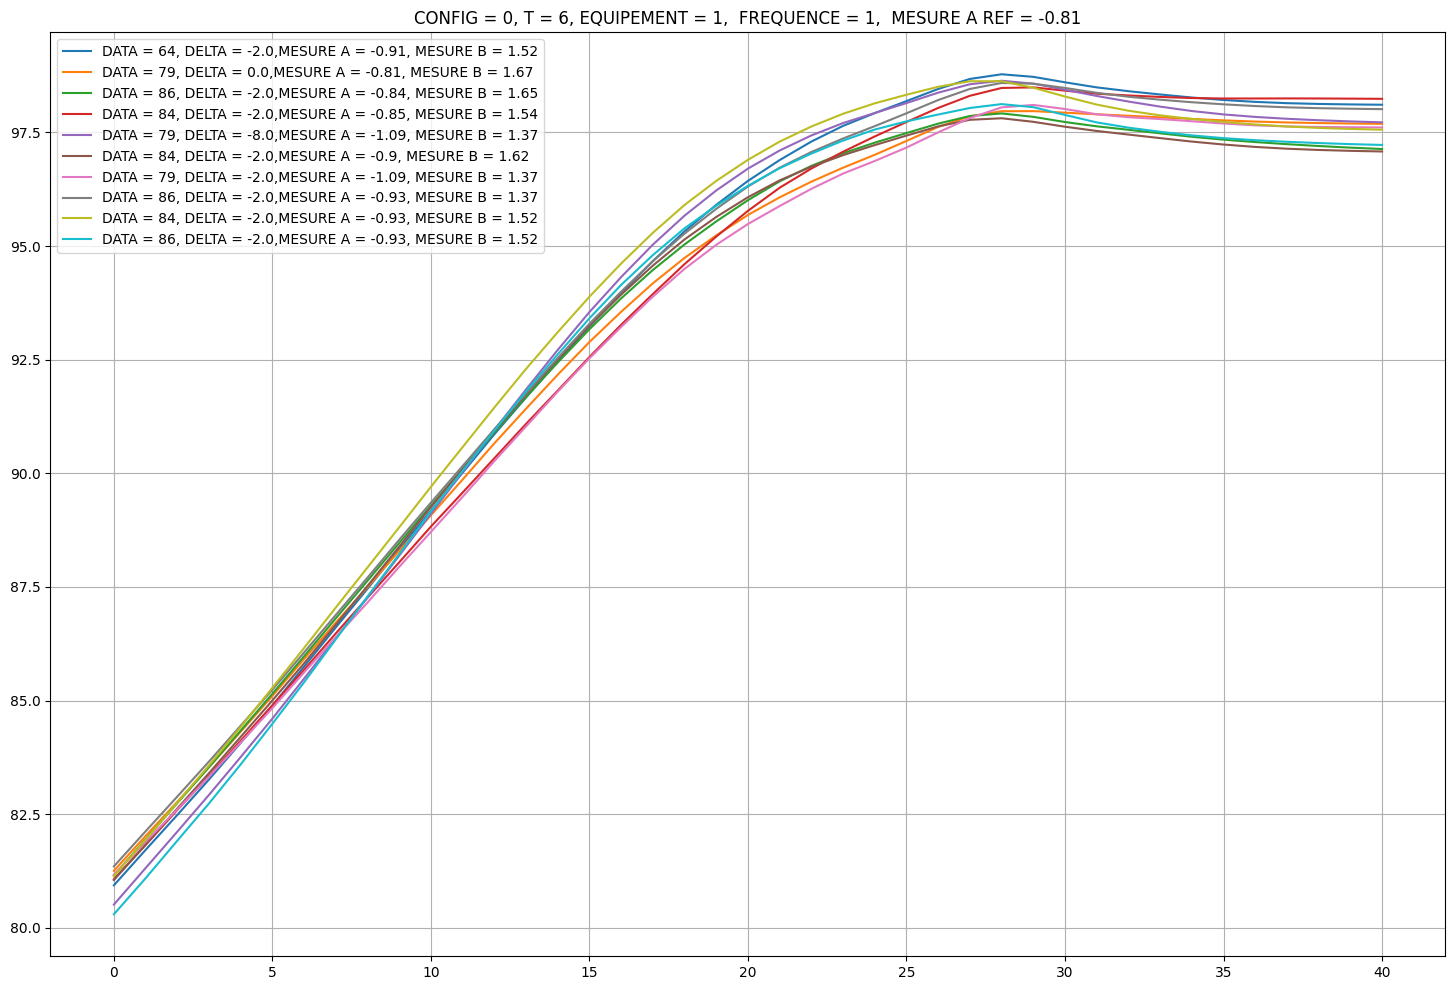

In [493]:
analyzer_pca.plot_syn_data_plus({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1,
    "MESURE A REF" : -0.81
}, noutput=10)

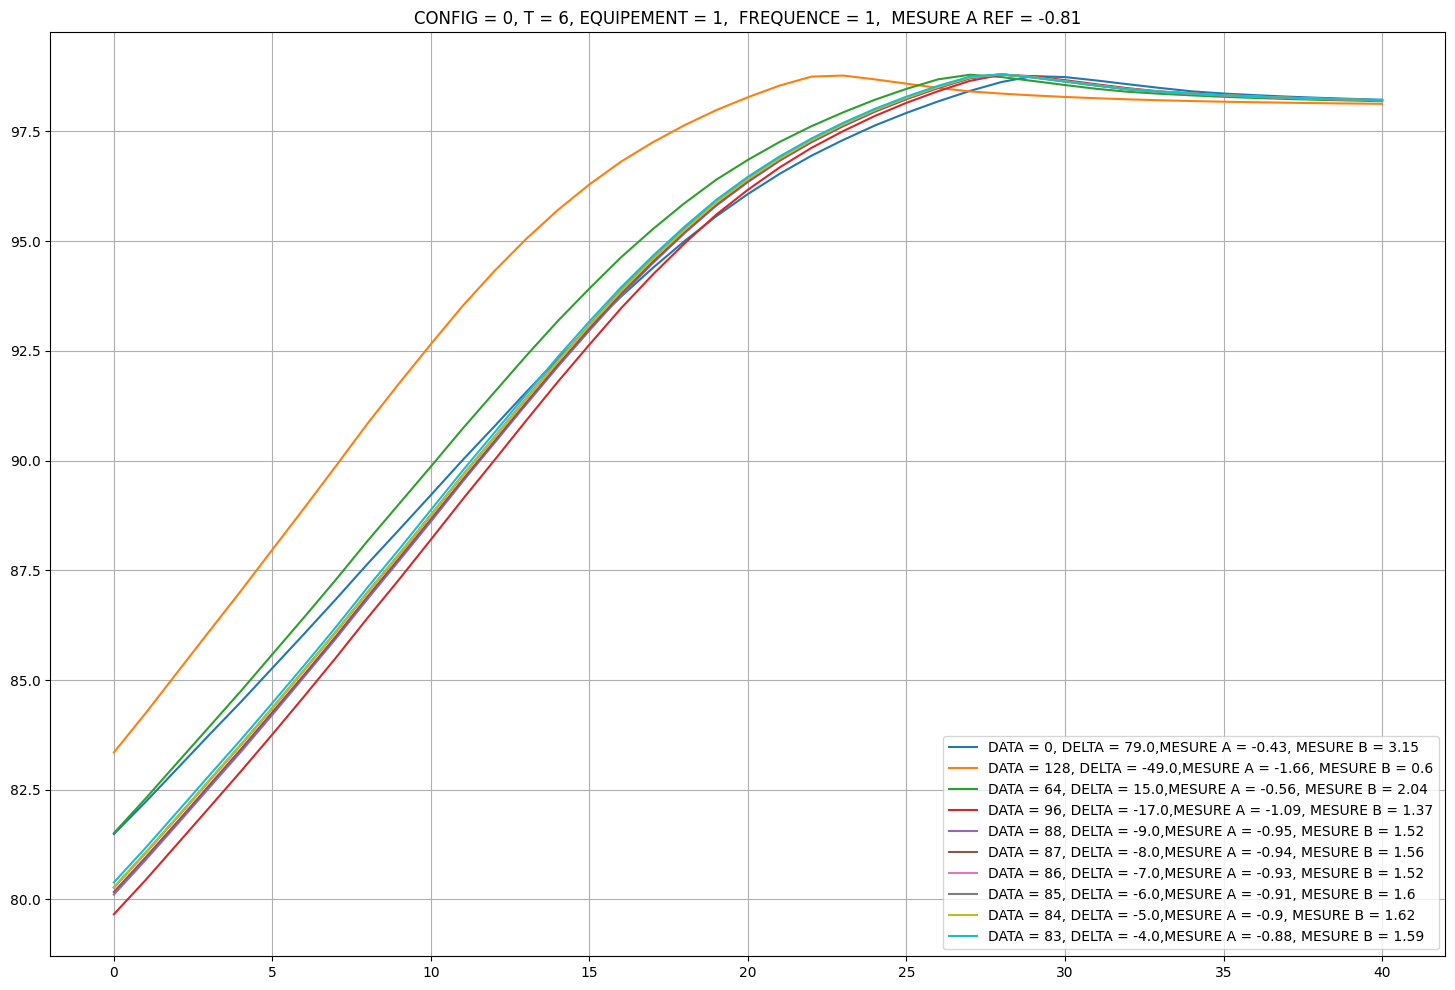

In [497]:
analyzer.plot_syn_data_plus({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1,
    "MESURE A REF" : -0.81
}, noutput=10)

In [624]:
cleaned_data["MESURE A REF"]

0      -0.980103
1      -0.980103
2      -0.980103
3      -0.980103
4      -0.980103
          ...   
4230   -1.093460
4231   -1.093460
4232   -0.717651
4233   -0.717651
4234   -0.717651
Name: MESURE A REF, Length: 4235, dtype: float64

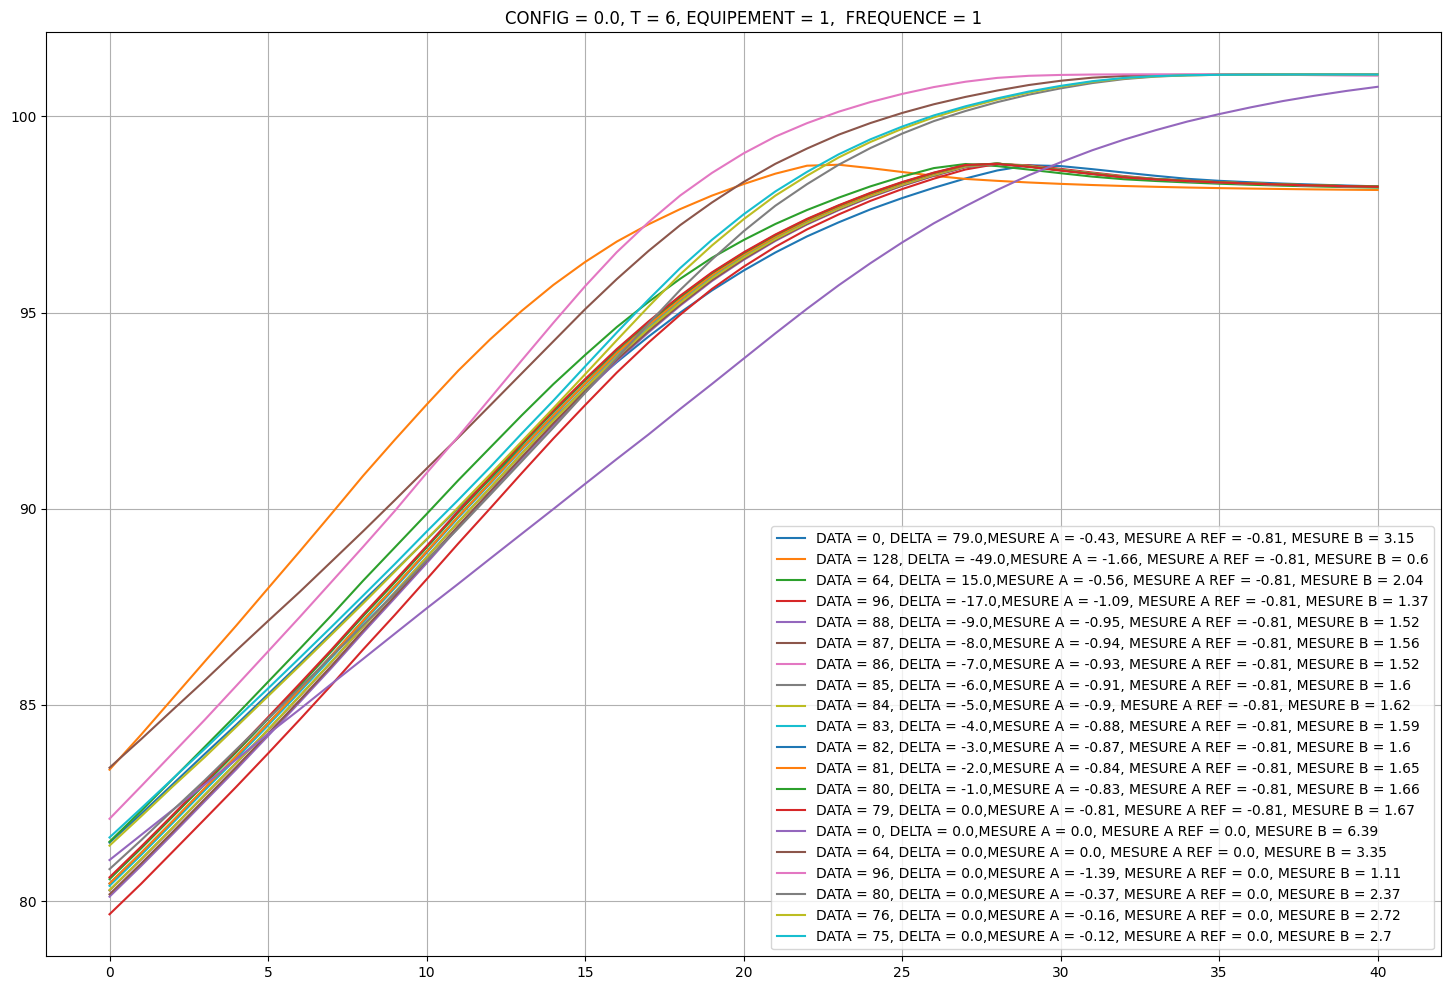

In [487]:
analyzer.plot_syn_data({
    "CONFIG" : 0,
    "T": 6,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 1
}, noutput=20)

# Train using TWD

In [39]:
trainable_data_ondelette = preprocessor.apply_wavelet_transform(cleaned_data = cleaned_data,cleaned_output =  cleaned_output, wavelet = 'db4', level = 1)

In [43]:
tvae_twd = TVAE(compress_dims= (512,256), decompress_dims= (256,512),latent_dim=256 ,track= True, verbose= True, loss_factor= 0.1,batch_size=300)
tvae_twd.fit(train_data= trainable_data_ondelette, discrete_columns= param_cols, lr= 0.01, project="TVAE_TWD")

Epoch 0/300 - Train Loss: 314.3366 (Rec: 280.6581, KL: 336.7854), Val Loss: 160.8247 (Rec: 142.5042, KL: 183.2053), LR: 0.010000, Patient: 0/20 
Epoch 5/300 - Train Loss: 64.2798 (Rec: 56.5697, KL: 77.1010), Val Loss: 43.7870 (Rec: 40.3446, KL: 34.4245), LR: 0.010000, Patient: 0/20 
Epoch 10/300 - Train Loss: 48.4080 (Rec: 43.7062, KL: 47.0185), Val Loss: 36.6336 (Rec: 34.2890, KL: 23.4463), LR: 0.010000, Patient: 1/20 
Epoch 15/300 - Train Loss: 41.4889 (Rec: 37.5866, KL: 39.0236), Val Loss: 30.9863 (Rec: 28.3428, KL: 26.4353), LR: 0.010000, Patient: 0/20 
Epoch 20/300 - Train Loss: 37.1163 (Rec: 33.7775, KL: 33.3879), Val Loss: 29.0185 (Rec: 26.7091, KL: 23.0935), LR: 0.010000, Patient: 1/20 
Epoch 25/300 - Train Loss: 32.9483 (Rec: 29.8177, KL: 31.3057), Val Loss: 28.2786 (Rec: 26.0041, KL: 22.7450), LR: 0.010000, Patient: 0/20 
Epoch 30/300 - Train Loss: 29.1923 (Rec: 26.4952, KL: 26.9707), Val Loss: 25.9432 (Rec: 23.9062, KL: 20.3705), LR: 0.010000, Patient: 0/20 
Epoch 35/300 - T

epoch,▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
learning_rate,████████████████████▄▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁
train_kl_divergence_loss,█▆▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▇▇▆▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_reconstruction_loss,█▆▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_kl_divergence_loss,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reconstruction_loss,▇█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,299
learning_rate,1e-05
train_kl_divergence_loss,14.85539


In [93]:
n = 4000
synthetic_data_twd = tvae_twd.sample(n)

In [95]:
output_inverse_twd = preprocessor.inverse_wavelet_transform(df_all_coeffs = synthetic_data_twd.iloc[:,9:], original_shape = (n, cleaned_output.shape[1]), wavelet='db4', level = 1)

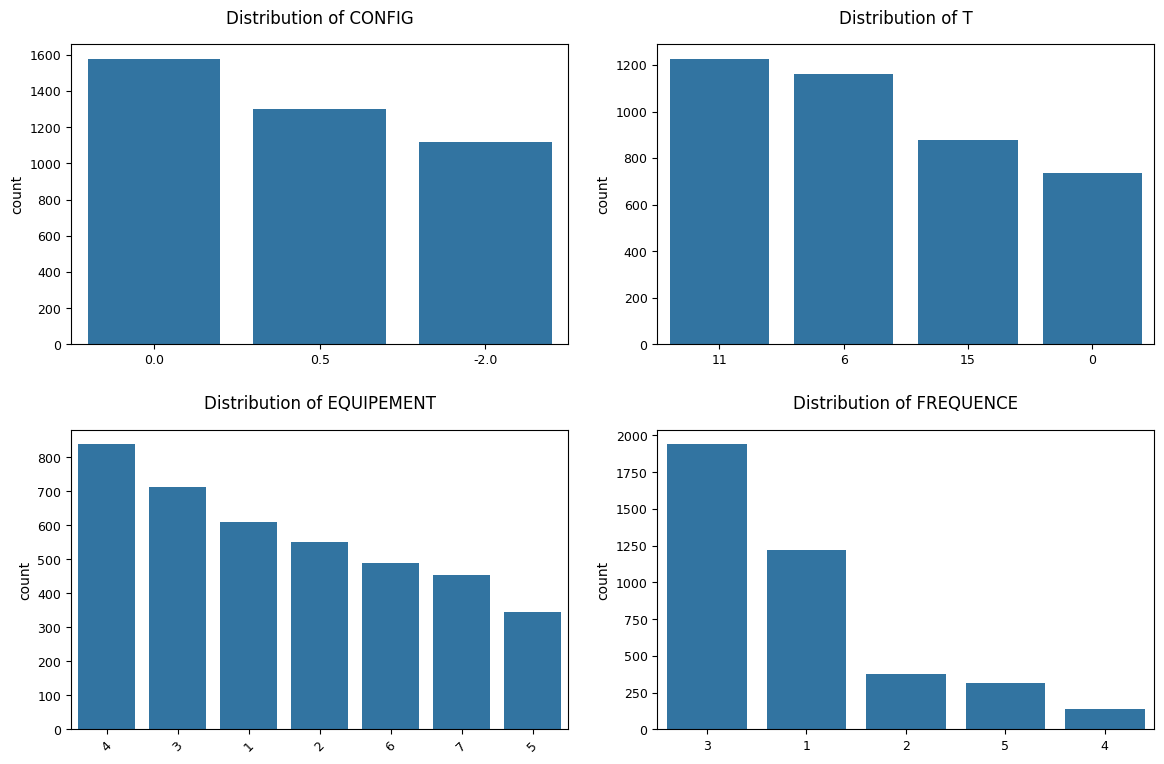

In [97]:
synthetic_data_twd = pd.concat([synthetic_data_twd.iloc[:,:9], output_inverse_twd], axis=1)

analyzer_twd = DataAnalyzer(synthetic_data_twd, numeric_columns = num_cols, categorical_columns= cat_cols)
cat_plot = analyzer.plot_distributions_cat()

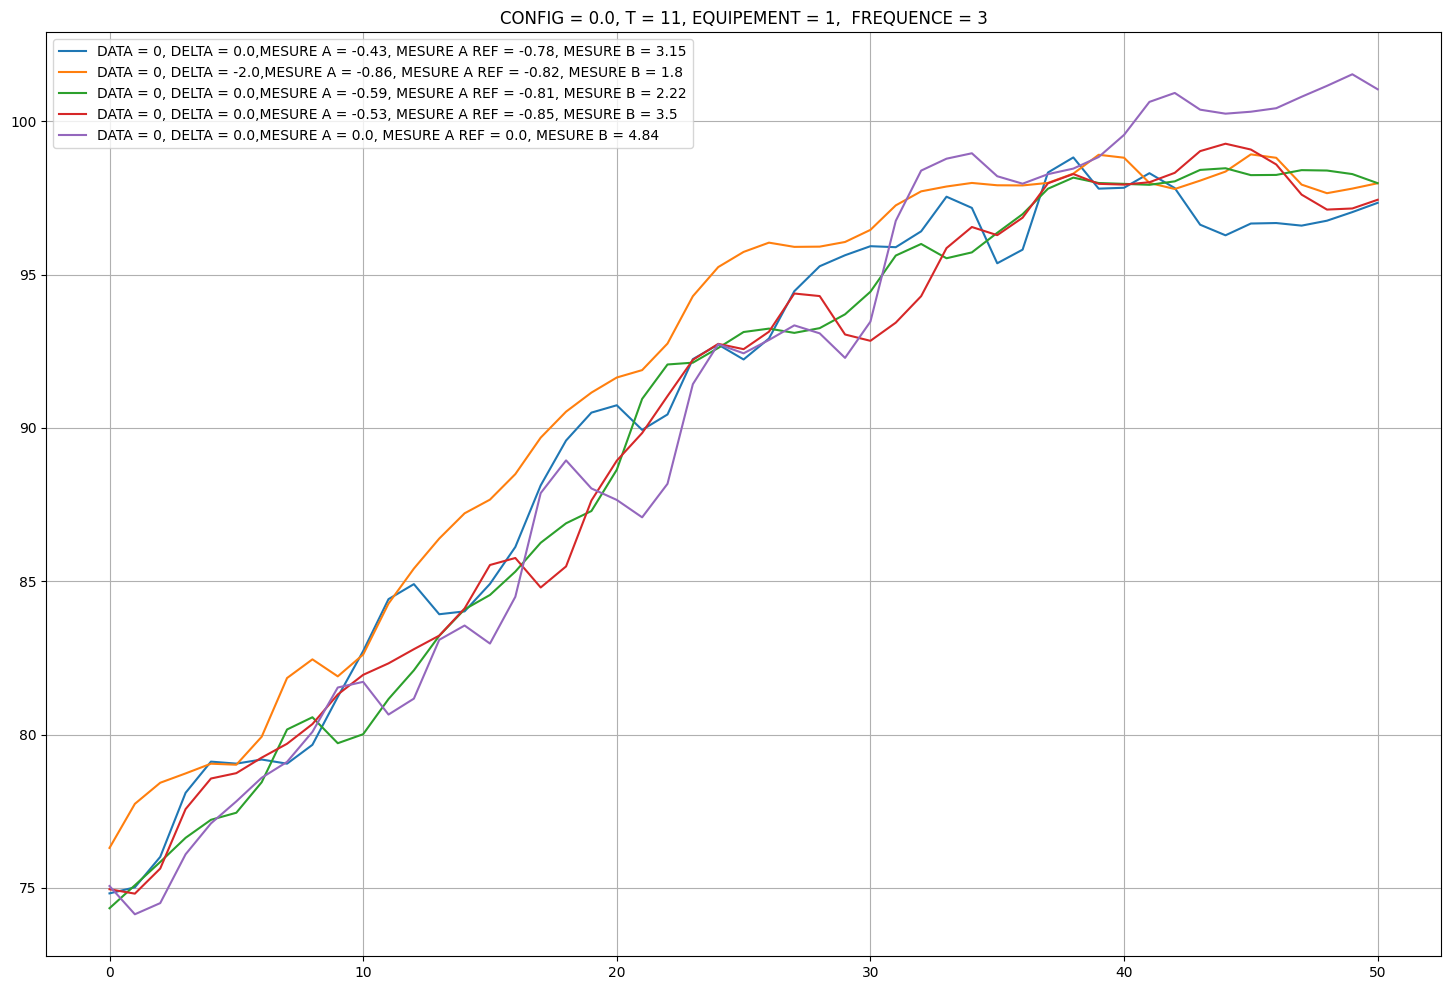

In [99]:
analyzer_twd.plot_syn_data({
    "CONFIG" : 0,
    "T": 11,
    "EQUIPEMENT" : 1,
    "FREQUENCE" : 3
})

# Evaluation

In [503]:
synthetic_data_pca

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,OUTPUT_60,...,OUTPUT_91,OUTPUT_92,OUTPUT_93,OUTPUT_94,OUTPUT_95,OUTPUT_96,OUTPUT_97,OUTPUT_98,OUTPUT_99,OUTPUT_100
0,84,0.5,6,5,0.0,-0.766198,-0.796675,1.454212,1,81.361558,...,98.857434,98.809064,98.771229,98.725156,98.678279,98.639075,98.609055,98.585955,98.566660,98.550329
1,176,0.5,15,5,0.0,-0.574683,-0.711223,1.976174,5,82.695522,...,98.872779,98.758183,98.682971,98.632590,98.598272,98.572208,98.550861,98.531813,98.515201,98.501442
2,0,0.5,6,6,-2.0,-0.703745,-0.793237,1.598091,5,81.890419,...,100.019611,100.019126,100.057184,100.108802,100.155820,100.194106,100.220678,100.235777,100.243797,100.247196
3,64,0.0,6,1,-2.0,-0.914371,-0.812476,1.523397,1,80.936761,...,98.488958,98.405148,98.332782,98.266085,98.211639,98.169899,98.141657,98.124673,98.113998,98.106914
4,186,0.0,15,1,0.0,-0.963543,-0.811196,1.202893,4,81.458901,...,98.592311,98.573248,98.578378,98.579662,98.572514,98.565988,98.565285,98.570742,98.578340,98.585450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,22,-2.0,6,7,0.0,-0.666627,-1.093460,2.156125,4,83.841749,...,93.489865,93.404186,93.339973,93.292648,93.260490,93.237407,93.219857,93.203852,93.189209,93.177123
4188,133,0.0,15,2,0.0,-0.095196,-0.095196,3.030240,1,81.517251,...,97.243930,97.278258,97.323318,97.363093,97.389139,97.404958,97.416048,97.426170,97.435570,97.443566
4189,88,-2.0,11,7,0.0,0.000000,-0.276243,6.445839,3,82.341128,...,96.204790,96.239794,96.269264,96.296094,96.321577,96.341928,96.353583,96.356036,96.353446,96.348915
4190,104,0.5,15,6,0.0,0.000000,0.000000,2.502041,1,84.365045,...,100.321807,100.425969,100.512703,100.576386,100.621711,100.656387,100.681754,100.699473,100.711479,100.719091


In [505]:
signal_cols = list(set(cleaned_data.columns) - set(param_cols) )
evaluation_pca = SyntheticDataEvaluator(real_data= cleaned_data, synthetic_data= synthetic_data_pca, categorical_cols= param_cols, signal_cols= signal_cols)

Données réelles: (4192, 50)
Données synthétiques: (4192, 50)


In [517]:
evaluation_pca.signal_analysis()

Énergie moyenne du signal:
  Réel: 362044.5003
  Synthétique: 362907.8711
  Différence: 0.24%

Similarité spectrale (FFT): 0.1601 (1=identique, 0=très différent)
Similarité d'autocorrélation: 0.9785 (1=identique, 0=très différent)


In [507]:
evaluation_pca.parameter_signal_coherence()

Nombre total de combinaisons de paramètres:
  Réel: 4192
  Synthétique: 3689
  Commun: 113

Analyse pour paramètres: {'CONFIG': np.float64(0.5), 'T': np.float64(6.0), 'EQUIPEMENT': np.float64(6.0), 'FREQUENCE': np.float64(5.0), 'DATA': np.float64(68.0), 'DELTA': np.float64(-2.0), 'MESURE A': np.float64(-0.8462731300000002), 'MESURE A REF': np.float64(-0.8118616299999957), 'MESURE B': np.float64(1.4603624565229725)}
  Échantillons réels: 1
  Échantillons synthétiques: 1
  Similarité du signal moyen: 0.9019


ValueError: array must not contain infs or NaNs

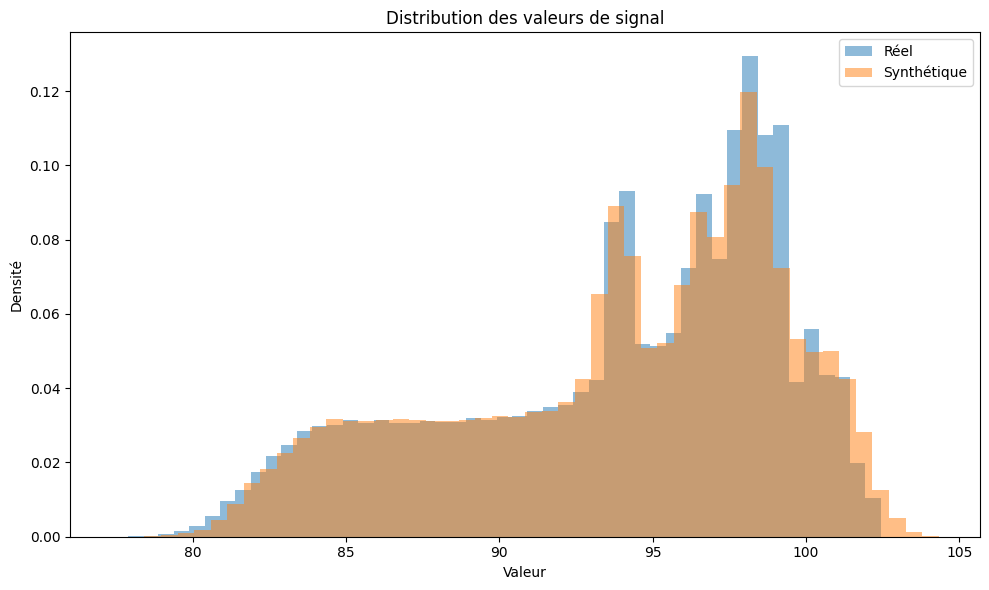

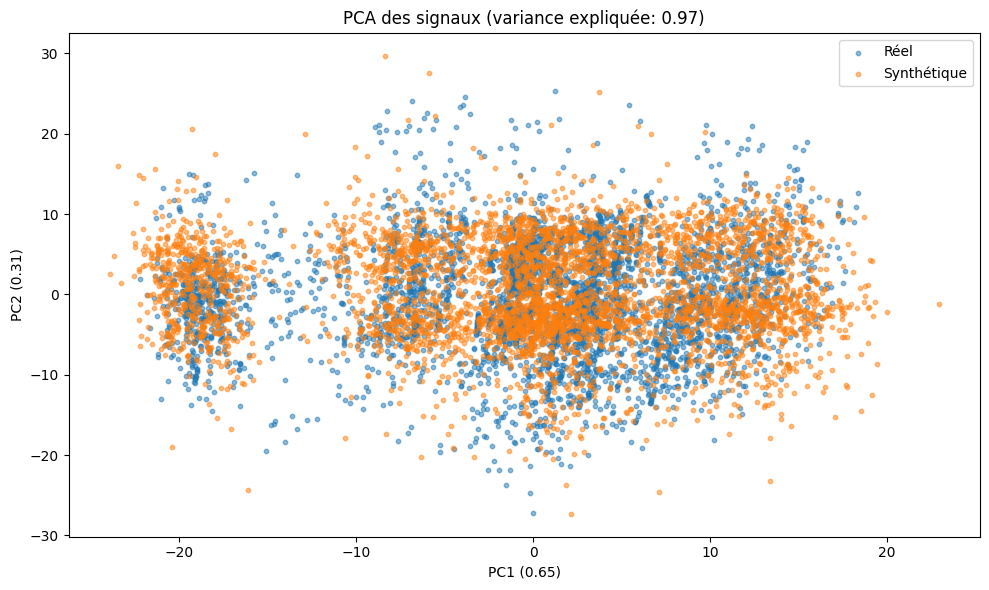

In [509]:
evaluation_pca.visualize_distributions()

In [511]:
evaluation_pca.supervised_evaluation()

Précision classification réel vs synthétique: 0.7917
Note: Une précision proche de 0.5 est idéale (le classifieur ne peut pas distinguer)

Matrice de confusion (normalisée):
             Prédit Réel  Prédit Synthétique
Réel            0.748230            0.251770
Synthétique     0.163855            0.836145

Test de prédiction de CONFIG à partir du signal:
  Réel → Réel: 0.9428
  Réel → Synthétique: 0.7063
  Synthétique → Synthétique: 0.7583
  Synthétique → Réel: 0.8411
